In this file I am using TEXT (combination of Title, Tagline and Overview) vectorized using BERT and REVENUE for the main feature to predict Movie Genres. Following the steps I performed:
1. Preprocess the dataset for BERT, just simple preprocessing since BERT knows context already.
2. Split the Train Dataset to be used in Modelling. It would be split into X_train, y_train, X_test, y_test.
3. Vectorizing and Embedding the X_train, X_test using TF-IDF and BERT.
4. Perform modelling using Random Forest, Log Regression, SVC, MLP and XGB Method.
5. So far, Log Regression give the best result either by F1 metrics or coverage-length metrics.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report



In [2]:
from google.colab import files
uploaded = files.upload()


Saving cleaned_test.csv to cleaned_test.csv
Saving cleaned_train.csv to cleaned_train.csv


In [3]:
df_train = pd.read_csv('cleaned_train.csv')
df_test = pd.read_csv('cleaned_test.csv')

In [4]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2386 entries, 0 to 2385
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2386 non-null   int64  
 1   budget             2386 non-null   float64
 2   homepage           857 non-null    object 
 3   original_language  2386 non-null   object 
 4   original_title     2386 non-null   object 
 5   overview           2386 non-null   object 
 6   release_date       2386 non-null   object 
 7   revenue            2386 non-null   float64
 8   runtime            2386 non-null   float64
 9   status             2386 non-null   object 
 10  tagline            1965 non-null   object 
 11  title              2386 non-null   object 
 12  vote_average       2386 non-null   float64
 13  vote_count         2386 non-null   float64
 14  Action             2386 non-null   int64  
 15  Adventure          2386 non-null   int64  
 16  Animation          2386 

In [5]:
# Dealing with Null Values
df_train['tagline'].fillna('-', inplace=True)

df_train['homepage'].fillna('-', inplace=True)


<ipython-input-5-ab96689c06d8>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['tagline'].fillna('-', inplace=True)
<ipython-input-5-ab96689c06d8>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2386 entries, 0 to 2385
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2386 non-null   int64  
 1   budget             2386 non-null   float64
 2   homepage           2386 non-null   object 
 3   original_language  2386 non-null   object 
 4   original_title     2386 non-null   object 
 5   overview           2386 non-null   object 
 6   release_date       2386 non-null   object 
 7   revenue            2386 non-null   float64
 8   runtime            2386 non-null   float64
 9   status             2386 non-null   object 
 10  tagline            2386 non-null   object 
 11  title              2386 non-null   object 
 12  vote_average       2386 non-null   float64
 13  vote_count         2386 non-null   float64
 14  Action             2386 non-null   int64  
 15  Adventure          2386 non-null   int64  
 16  Animation          2386 

### 1. PREPROCESS THE TEXT COLUMNS (FOR BERT AND TF-IDF)

In [7]:
!pip install unidecode


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.5 MB/s eta 0:00:00


In [8]:
import pandas as pd
import html
import re
import string
import unidecode
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from tqdm import tqdm

# Download NLTK resources (jalankan sekali)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

# Inisialisasi
lemmatizer = WordNetLemmatizer()
default_stopwords = set(stopwords.words('english'))
custom_stopwords = {
    'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'i',
    'movie', 'film', 'new', 'story', 'th', 'man', 'men', 'woman', 'women',
    'boy', 'girl', 'world', 'life'
}
all_stopwords = default_stopwords.union(custom_stopwords)
punctuation_table = str.maketrans('', '', string.punctuation)

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [9]:
def text_preprocess_tfidf(sentence):
    if not isinstance(sentence, str) or not sentence.strip():
        return ""

    sentence = sentence.lower()
    sentence = html.unescape(re.sub(r'<[^>]+>', '', sentence))
    sentence = re.sub(r'http\S+|www\S+|https\S+|\S+@\S+', '', sentence, flags=re.MULTILINE)
    sentence = sentence.translate(punctuation_table)
    sentence = re.sub(r'\d+', '', sentence)
    sentence = unidecode.unidecode(sentence)

    words = word_tokenize(sentence)
    tagged_words = pos_tag(words)

    processed_words = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in tagged_words
        if word.isalpha() and word not in all_stopwords and len(word) > 2
    ]

    return ' '.join(processed_words)


In [10]:
def text_preprocess_bert(text):
    if not isinstance(text, str) or not text.strip():
        return ""
    text = html.unescape(text)
    text = unidecode.unidecode(text)
    text = re.sub(r'http\S+|www\S+|https\S+|\S+@\S+', '', text, flags=re.MULTILINE)
    text = text.lower()
    return text.strip()


In [11]:
def combine_columns(df, col_prefix, func):
    return df.apply(lambda row:
        func(str(row['title'])) + ' ' +
        func(str(row['tagline'])) + ' ' +
        func(str(row['overview'])),
        axis=1
    )

# Asumsikan df_train dan df_test sudah tersedia
tqdm.pandas()

df_train['text_tfidf'] = combine_columns(df_train, 'processed', text_preprocess_tfidf)
df_test['text_tfidf'] = combine_columns(df_test, 'processed', text_preprocess_tfidf)

df_train['text_bert'] = combine_columns(df_train, 'processed', text_preprocess_bert)
df_test['text_bert'] = combine_columns(df_test, 'processed', text_preprocess_bert)


In [12]:
##Checkpoint: The preprocessed columns
genre_columns = df_train.columns[14:34]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2386 entries, 0 to 2385
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2386 non-null   int64  
 1   budget             2386 non-null   float64
 2   homepage           2386 non-null   object 
 3   original_language  2386 non-null   object 
 4   original_title     2386 non-null   object 
 5   overview           2386 non-null   object 
 6   release_date       2386 non-null   object 
 7   revenue            2386 non-null   float64
 8   runtime            2386 non-null   float64
 9   status             2386 non-null   object 
 10  tagline            2386 non-null   object 
 11  title              2386 non-null   object 
 12  vote_average       2386 non-null   float64
 13  vote_count         2386 non-null   float64
 14  Action             2386 non-null   int64  
 15  Adventure          2386 non-null   int64  
 16  Animation          2386 

### 2. SPLITTING THE TRAIN DATASET (with Text as features)

In [13]:
!pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.1 MB/s eta 0:00:00


In [15]:
import numpy as np
from skmultilearn.model_selection import iterative_train_test_split

# Target genre
genre_columns = df_train.columns[14:34]
y = df_train[genre_columns].values

X_base = np.arange(len(df_train)).reshape(-1, 1)

# Split
X_train_idx, y_train, X_test_idx, y_test = iterative_train_test_split(X_base, y, test_size=0.2)

train_indices = X_train_idx.ravel()
test_indices = X_test_idx.ravel()

X_train_tfidf = df_train.loc[train_indices, 'text_tfidf'].values
X_test_tfidf = df_train.loc[test_indices, 'text_tfidf'].values

X_train_bert = df_train.loc[train_indices, 'text_bert'].values
X_test_bert = df_train.loc[test_indices, 'text_bert'].values


In [16]:
print(X_train_bert)
print(X_train_tfidf)

['lonesome jim - failing to make it on his own, 27-year-old jim moves back in with his parents and deals with crippling family obligations.'
 'existenz play it. live it. kill for it. a game designer on the run from assassins must play her latest virtual reality creation with a marketing trainee to determine if the game has been damaged.'
 "couples retreat it may be paradise... but it's no vacation. four couples, all friends, descend on a tropical island resort. though one husband and wife are there to work on their marriage, the others just want to enjoy some fun in the sun. they soon find, however, that paradise comes at a price: participation in couples therapy sessions is mandatory. what started out as a cut-rate vacation turns into an examination of the common problems many face."
 ... 'khiladi 786 - the 8th installment in the khiladi series.'
 'the wailing never be tempted. a stranger arrives in a little village and soon after a mysterious sickness starts spreading. a policeman is

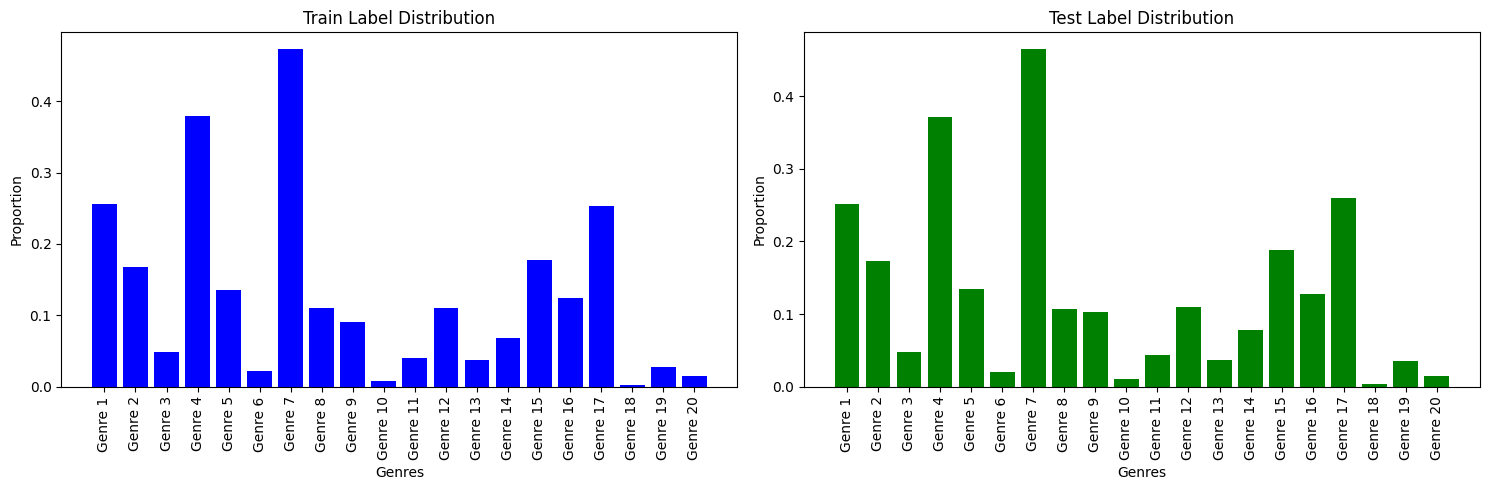

In [ ]:
# Checkpoint
import numpy as np
import matplotlib.pyplot as plt

def label_distribution(y):
    return np.sum(y, axis=0) / y.shape[0]

train_distribution = label_distribution(y_train)
test_distribution = label_distribution(y_test)

# Plotting the bar chart
labels = [f"Genre {i+1}" for i in range(len(train_distribution))]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Train label distribution bar chart
ax[0].bar(labels, train_distribution, color='blue')
ax[0].set_title("Train Label Distribution")
ax[0].set_xlabel("Genres")
ax[0].set_ylabel("Proportion")
ax[0].tick_params(axis='x', rotation=90)

# Test label distribution bar chart
ax[1].bar(labels, test_distribution, color='green')
ax[1].set_title("Test Label Distribution")
ax[1].set_xlabel("Genres")
ax[1].set_ylabel("Proportion")
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()



### 3. TEXT VECTORIZE AND EMBEDDING

In [ ]:
!pip install transformers datasets


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from scipy.sparse import hstack, csr_matrix
import numpy as np

# TF-IDF VECTORIZER
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf_vec = tfidf_vectorizer.fit_transform(X_train_tfidf)
X_test_tfidf_vec = tfidf_vectorizer.transform(X_test_tfidf)

# BERT ENCODING
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

X_train_bert_vec = bert_model.encode(X_train_bert, show_progress_bar=True)
X_test_bert_vec = bert_model.encode(X_test_bert, show_progress_bar=True)

# COMBINE TF-IDF + BERT

X_train_bert_sparse = csr_matrix(X_train_bert_vec)
X_test_bert_sparse = csr_matrix(X_test_bert_vec)

X_train_combined = hstack([X_train_tfidf_vec, X_train_bert_sparse])
X_test_combined = hstack([X_test_tfidf_vec, X_test_bert_sparse])



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/60 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

### 4. MODELLING

### 4.1. RANDOM FOREST

In [18]:
from sklearn.ensemble import RandomForestClassifier
# rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample')  # You can tune parameters
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=25,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced_subsample',
    criterion='entropy',
    random_state=42
)
rf_model_multi = MultiOutputClassifier(rf_model)

# Train the model with binarized labels
rf_model_multi.fit(X_train_combined, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                       criterion='entropy',
                                                       max_depth=25,
                                                       min_samples_leaf=5,
                                                       min_samples_split=10,
                                                       n_estimators=300,
                                                       random_state=42))

In [19]:
import numpy as np

# Probabilitas prediksi (n_samples, n_labels)
y_test_probs_rf = np.array([
    estimator.predict_proba(X_test_combined)[:, 1]
    for estimator in rf_model_multi.estimators_
]).T

def build_conformal_sets(y_prob, threshold):
    return (y_prob >= threshold).astype(int)

def evaluate_conformal_sets(y_true, y_pred_sets):
    n = y_true.shape[0]

    is_covered = [
        set(np.where(y_true[i] == 1)[0]).issubset(set(np.where(y_pred_sets[i] == 1)[0]))
        for i in range(n)
    ]
    coverage = 1 if np.mean(is_covered) >= 0.9 else 0

    avg_len = np.mean(np.sum(y_pred_sets, axis=1))
    length = 1 - (avg_len / y_true.shape[1])

    metric = 0.5 * (coverage + length)

    return coverage, length, metric



In [20]:
thresholds = np.linspace(0.1, 0.9, 17)
best_metric = -1
best_threshold = None

for t in thresholds:
    y_pred_rf_val = build_conformal_sets(y_test_probs_rf, t)
    coverage, length, metric = evaluate_conformal_sets(y_test, y_pred_rf_val)
    print(f"Threshold={t:.2f} | Coverage={coverage} | Length={length:.4f} | Metric={metric:.4f}")

    if metric > best_metric:
        best_metric = metric
        best_threshold = t

print(f"\n✅ Best Threshold (Validation): {best_threshold:.2f}")
print(f"📊 Best Simulated Metric (Kaggle-style): {best_metric:.4f}")


Threshold=0.10 | Coverage=1 | Length=0.4054 | Metric=0.7027
Threshold=0.15 | Coverage=0 | Length=0.5524 | Metric=0.2762
Threshold=0.20 | Coverage=0 | Length=0.6693 | Metric=0.3346
Threshold=0.25 | Coverage=0 | Length=0.7490 | Metric=0.3745
Threshold=0.30 | Coverage=0 | Length=0.8050 | Metric=0.4025
Threshold=0.35 | Coverage=0 | Length=0.8550 | Metric=0.4275
Threshold=0.40 | Coverage=0 | Length=0.8927 | Metric=0.4464
Threshold=0.45 | Coverage=0 | Length=0.9255 | Metric=0.4628
Threshold=0.50 | Coverage=0 | Length=0.9554 | Metric=0.4777
Threshold=0.55 | Coverage=0 | Length=0.9782 | Metric=0.4891
Threshold=0.60 | Coverage=0 | Length=0.9918 | Metric=0.4959
Threshold=0.65 | Coverage=0 | Length=0.9979 | Metric=0.4990
Threshold=0.70 | Coverage=0 | Length=0.9996 | Metric=0.4998
Threshold=0.75 | Coverage=0 | Length=1.0000 | Metric=0.5000
Threshold=0.80 | Coverage=0 | Length=1.0000 | Metric=0.5000
Threshold=0.85 | Coverage=0 | Length=1.0000 | Metric=0.5000
Threshold=0.90 | Coverage=0 | Length=1.0

In [ ]:
# EVALUATION WITH F1 SCORE

In [ ]:
print(X_train_combined.shape)
print(y_train.shape)
print(len(X_train_tfidf))  # Harus 1904
print(len(X_train_bert))   # Harus 1904
print(y_train.shape)       # Harus (1904, 20)



(1904, 5384)
(1904, 20)
1904
1904
(1904, 20)


In [ ]:
from sklearn.metrics import classification_report

# Prediksi
y_pred_rf_comb = rf_model_multi.predict(X_test_combined)

# Evaluasi
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_rf_comb, target_names=genre_columns))

                 precision    recall  f1-score   support

         Action       0.90      0.23      0.37       122
      Adventure       0.67      0.05      0.09        83
      Animation       0.00      0.00      0.00        23
         Comedy       0.72      0.41      0.52       180
          Crime       1.00      0.05      0.09        65
    Documentary       0.00      0.00      0.00        10
          Drama       0.62      0.57      0.60       225
         Family       0.67      0.04      0.07        52
        Fantasy       0.00      0.00      0.00        50
        Foreign       0.00      0.00      0.00         5
        History       0.00      0.00      0.00        21
         Horror       0.89      0.15      0.26        53
          Music       0.00      0.00      0.00        18
        Mystery       0.00      0.00      0.00        36
        Romance       0.88      0.16      0.28        91
Science.Fiction       1.00      0.07      0.12        61
       Thriller       0.79    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 4.2. LOG REGRESSION

In [21]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

# Menambahkan parameter class_weight='balanced' untuk mengatasi data imbalance
# lr = OneVsRestClassifier(LogisticRegression(max_iter=3000, class_weight='balanced'))
lr = OneVsRestClassifier(
    LogisticRegression(
        C=1.5,                    # regularisasi lebih kuat (tweak ini)
        penalty='l2',             # default, aman
        solver='liblinear',       # cocok buat dataset kecil-menengah
        class_weight='balanced', # ini penting buat imbalance
        max_iter=3000,
        random_state=42
    ),
    n_jobs=-1  # untuk training paralel per-label
)
lr.fit(X_train_combined, y_train)


OneVsRestClassifier(estimator=LogisticRegression(C=1.5, class_weight='balanced',
                                                 max_iter=3000, random_state=42,
                                                 solver='liblinear'),
                    n_jobs=-1)

In [22]:
import numpy as np

# Probabilitas prediksi (n_samples, n_labels)
y_test_probs_lr = np.array([
    estimator.predict_proba(X_test_combined)[:, 1]
    for estimator in lr.estimators_
]).T

def build_conformal_sets(y_prob, threshold):
    return (y_prob >= threshold).astype(int)

def evaluate_conformal_sets(y_true, y_pred_sets):
    n = y_true.shape[0]

    is_covered = [
        set(np.where(y_true[i] == 1)[0]).issubset(set(np.where(y_pred_sets[i] == 1)[0]))
        for i in range(n)
    ]
    coverage = 1 if np.mean(is_covered) >= 0.9 else 0

    avg_len = np.mean(np.sum(y_pred_sets, axis=1))
    length = 1 - (avg_len / y_true.shape[1])

    metric = 0.5 * (coverage + length)

    return coverage, length, metric



In [23]:
thresholds = np.linspace(0.1, 0.9, 17)
best_metric = -1
best_threshold = None

for t in thresholds:
    y_pred_lr_val = build_conformal_sets(y_test_probs_lr, t)
    coverage, length, metric = evaluate_conformal_sets(y_test, y_pred_lr_val)
    print(f"Threshold={t:.2f} | Coverage={coverage} | Length={length:.4f} | Metric={metric:.4f}")

    if metric > best_metric:
        best_metric = metric
        best_threshold = t

print(f"\n✅ Best Threshold (Validation): {best_threshold:.2f}")
print(f"📊 Best Simulated Metric (Kaggle-style): {best_metric:.4f}")


Threshold=0.10 | Coverage=1 | Length=0.5170 | Metric=0.7585
Threshold=0.15 | Coverage=0 | Length=0.6076 | Metric=0.3038
Threshold=0.20 | Coverage=0 | Length=0.6714 | Metric=0.3357
Threshold=0.25 | Coverage=0 | Length=0.7152 | Metric=0.3576
Threshold=0.30 | Coverage=0 | Length=0.7502 | Metric=0.3751
Threshold=0.35 | Coverage=0 | Length=0.7806 | Metric=0.3903
Threshold=0.40 | Coverage=0 | Length=0.8085 | Metric=0.4043
Threshold=0.45 | Coverage=0 | Length=0.8289 | Metric=0.4145
Threshold=0.50 | Coverage=0 | Length=0.8483 | Metric=0.4242
Threshold=0.55 | Coverage=0 | Length=0.8697 | Metric=0.4349
Threshold=0.60 | Coverage=0 | Length=0.8876 | Metric=0.4438
Threshold=0.65 | Coverage=0 | Length=0.9059 | Metric=0.4530
Threshold=0.70 | Coverage=0 | Length=0.9213 | Metric=0.4606
Threshold=0.75 | Coverage=0 | Length=0.9367 | Metric=0.4684
Threshold=0.80 | Coverage=0 | Length=0.9512 | Metric=0.4756
Threshold=0.85 | Coverage=0 | Length=0.9652 | Metric=0.4826
Threshold=0.90 | Coverage=0 | Length=0.9

In [24]:
# F1 SCORE

In [ ]:

# Predict
y_pred_lr_comb = lr.predict(X_test_combined)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred_lr_comb, target_names=genre_columns))

                 precision    recall  f1-score   support

         Action       0.63      0.70      0.66       122
      Adventure       0.52      0.67      0.59        83
      Animation       0.44      0.35      0.39        23
         Comedy       0.65      0.77      0.71       180
          Crime       0.52      0.65      0.58        65
    Documentary       0.50      0.50      0.50        10
          Drama       0.65      0.70      0.67       225
         Family       0.52      0.62      0.56        52
        Fantasy       0.48      0.58      0.52        50
        Foreign       0.00      0.00      0.00         5
        History       0.41      0.57      0.48        21
         Horror       0.61      0.77      0.68        53
          Music       0.48      0.61      0.54        18
        Mystery       0.31      0.36      0.33        36
        Romance       0.57      0.73      0.64        91
Science.Fiction       0.66      0.74      0.70        61
       Thriller       0.54    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
y_probs = lr.predict_proba(X_test_combined)
y_pred_custom = (y_probs >= 0.475).astype(int)

print(classification_report(y_test, y_pred_custom, target_names=genre_columns))


                 precision    recall  f1-score   support

         Action       0.63      0.75      0.68       122
      Adventure       0.50      0.70      0.58        83
      Animation       0.36      0.39      0.38        23
         Comedy       0.65      0.80      0.72       180
          Crime       0.51      0.68      0.58        65
    Documentary       0.50      0.50      0.50        10
          Drama       0.64      0.74      0.68       225
         Family       0.50      0.67      0.57        52
        Fantasy       0.45      0.60      0.51        50
        Foreign       0.00      0.00      0.00         5
        History       0.39      0.62      0.48        21
         Horror       0.58      0.79      0.67        53
          Music       0.42      0.61      0.50        18
        Mystery       0.27      0.36      0.31        36
        Romance       0.56      0.77      0.65        91
Science.Fiction       0.63      0.75      0.69        61
       Thriller       0.54    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 4.3. MLP

In [25]:
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# Create an MLPClassifier model (Neural Network)
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

# Wrap the MLPClassifier in MultiOutputClassifier for multi-label classification
mlp_model_multi = MultiOutputClassifier(mlp_model)

# Train the model on the training data
mlp_model_multi.fit(X_train_combined, y_train)

MultiOutputClassifier(estimator=MLPClassifier(hidden_layer_sizes=(100, 50),
                                              max_iter=1000, random_state=42))

In [26]:
import numpy as np

# Probabilitas prediksi (n_samples, n_labels)
y_test_probs_mlp = np.array([
    estimator.predict_proba(X_test_combined)[:, 1]
    for estimator in mlp_model_multi.estimators_
]).T

def build_conformal_sets(y_prob, threshold):
    return (y_prob >= threshold).astype(int)

def evaluate_conformal_sets(y_true, y_pred_sets):
    n = y_true.shape[0]

    is_covered = [
        set(np.where(y_true[i] == 1)[0]).issubset(set(np.where(y_pred_sets[i] == 1)[0]))
        for i in range(n)
    ]
    coverage = 1 if np.mean(is_covered) >= 0.9 else 0

    avg_len = np.mean(np.sum(y_pred_sets, axis=1))
    length = 1 - (avg_len / y_true.shape[1])

    metric = 0.5 * (coverage + length)

    return coverage, length, metric



In [27]:
thresholds = np.linspace(0.1, 0.9, 17)
best_metric = -1
best_threshold = None

for t in thresholds:
    y_pred_mlp_val = build_conformal_sets(y_test_probs_mlp, t)
    coverage, length, metric = evaluate_conformal_sets(y_test, y_pred_mlp_val)
    print(f"Threshold={t:.2f} | Coverage={coverage} | Length={length:.4f} | Metric={metric:.4f}")

    if metric > best_metric:
        best_metric = metric
        best_threshold = t

print(f"\n✅ Best Threshold (Validation): {best_threshold:.2f}")
print(f"📊 Best Simulated Metric (Kaggle-style): {best_metric:.4f}")


Threshold=0.10 | Coverage=0 | Length=0.8701 | Metric=0.4351
Threshold=0.15 | Coverage=0 | Length=0.8788 | Metric=0.4394
Threshold=0.20 | Coverage=0 | Length=0.8850 | Metric=0.4425
Threshold=0.25 | Coverage=0 | Length=0.8900 | Metric=0.4450
Threshold=0.30 | Coverage=0 | Length=0.8968 | Metric=0.4484
Threshold=0.35 | Coverage=0 | Length=0.9004 | Metric=0.4502
Threshold=0.40 | Coverage=0 | Length=0.9037 | Metric=0.4519
Threshold=0.45 | Coverage=0 | Length=0.9060 | Metric=0.4530
Threshold=0.50 | Coverage=0 | Length=0.9089 | Metric=0.4545
Threshold=0.55 | Coverage=0 | Length=0.9120 | Metric=0.4560
Threshold=0.60 | Coverage=0 | Length=0.9155 | Metric=0.4577
Threshold=0.65 | Coverage=0 | Length=0.9192 | Metric=0.4596
Threshold=0.70 | Coverage=0 | Length=0.9220 | Metric=0.4610
Threshold=0.75 | Coverage=0 | Length=0.9261 | Metric=0.4631
Threshold=0.80 | Coverage=0 | Length=0.9296 | Metric=0.4648
Threshold=0.85 | Coverage=0 | Length=0.9354 | Metric=0.4677
Threshold=0.90 | Coverage=0 | Length=0.9

In [28]:
# F1 SCORE

In [ ]:
# Predict
y_pred_nn_comb = mlp_model_multi.predict(X_test_combined)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred_nn_comb, target_names=genre_columns))

                 precision    recall  f1-score   support

         Action       0.70      0.57      0.63       122
      Adventure       0.68      0.36      0.47        83
      Animation       0.50      0.09      0.15        23
         Comedy       0.65      0.66      0.66       180
          Crime       0.69      0.34      0.45        65
    Documentary       0.67      0.20      0.31        10
          Drama       0.69      0.68      0.68       225
         Family       0.64      0.31      0.42        52
        Fantasy       0.56      0.18      0.27        50
        Foreign       0.00      0.00      0.00         5
        History       0.00      0.00      0.00        21
         Horror       0.79      0.62      0.69        53
          Music       0.75      0.33      0.46        18
        Mystery       0.17      0.03      0.05        36
        Romance       0.65      0.41      0.50        91
Science.Fiction       0.79      0.43      0.55        61
       Thriller       0.60    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 4.4. SVM

In [29]:
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, hamming_loss

svm = SVC(
    kernel='rbf',
    C=10,
    gamma=0.1,
    class_weight='balanced',
    tol=1e-6,
    max_iter=10000,
    probability=True
)
multi_svm = MultiOutputClassifier(svm)
multi_svm.fit(X_train_combined, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


MultiOutputClassifier(estimator=SVC(C=10, class_weight='balanced', gamma=0.1,
                                    max_iter=10000, probability=True,
                                    tol=1e-06))

In [30]:
import numpy as np

# Probabilitas prediksi (n_samples, n_labels)
y_test_probs_svc = np.array([
    estimator.predict_proba(X_test_combined)[:, 1]
    for estimator in multi_svm.estimators_
]).T

def build_conformal_sets(y_prob, threshold):
    return (y_prob >= threshold).astype(int)

def evaluate_conformal_sets(y_true, y_pred_sets):
    n = y_true.shape[0]

    is_covered = [
        set(np.where(y_true[i] == 1)[0]).issubset(set(np.where(y_pred_sets[i] == 1)[0]))
        for i in range(n)
    ]
    coverage = 1 if np.mean(is_covered) >= 0.9 else 0

    avg_len = np.mean(np.sum(y_pred_sets, axis=1))
    length = 1 - (avg_len / y_true.shape[1])

    metric = 0.5 * (coverage + length)

    return coverage, length, metric



In [31]:
thresholds = np.linspace(0.1, 0.9, 17)
best_metric = -1
best_threshold = None

for t in thresholds:
    y_pred_svc_val = build_conformal_sets(y_test_probs_svc, t)
    coverage, length, metric = evaluate_conformal_sets(y_test, y_pred_svc_val)
    print(f"Threshold={t:.2f} | Coverage={coverage} | Length={length:.4f} | Metric={metric:.4f}")

    if metric > best_metric:
        best_metric = metric
        best_threshold = t

print(f"\n✅ Best Threshold (Validation): {best_threshold:.2f}")
print(f"📊 Best Simulated Metric (Kaggle-style): {best_metric:.4f}")


Threshold=0.10 | Coverage=0 | Length=0.7030 | Metric=0.3515
Threshold=0.15 | Coverage=0 | Length=0.7610 | Metric=0.3805
Threshold=0.20 | Coverage=0 | Length=0.7974 | Metric=0.3987
Threshold=0.25 | Coverage=0 | Length=0.8242 | Metric=0.4121
Threshold=0.30 | Coverage=0 | Length=0.8483 | Metric=0.4242
Threshold=0.35 | Coverage=0 | Length=0.8687 | Metric=0.4343
Threshold=0.40 | Coverage=0 | Length=0.8851 | Metric=0.4425
Threshold=0.45 | Coverage=0 | Length=0.8995 | Metric=0.4497
Threshold=0.50 | Coverage=0 | Length=0.9118 | Metric=0.4559
Threshold=0.55 | Coverage=0 | Length=0.9247 | Metric=0.4623
Threshold=0.60 | Coverage=0 | Length=0.9356 | Metric=0.4678
Threshold=0.65 | Coverage=0 | Length=0.9464 | Metric=0.4732
Threshold=0.70 | Coverage=0 | Length=0.9563 | Metric=0.4782
Threshold=0.75 | Coverage=0 | Length=0.9662 | Metric=0.4831
Threshold=0.80 | Coverage=0 | Length=0.9761 | Metric=0.4881
Threshold=0.85 | Coverage=0 | Length=0.9835 | Metric=0.4918
Threshold=0.90 | Coverage=0 | Length=0.9

In [32]:
# F1 SCORE

In [ ]:
# Predict
y_pred_svc_comb = multi_svm.predict(X_test_combined)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred_svc_comb, target_names=genre_columns))

                 precision    recall  f1-score   support

         Action       0.73      0.64      0.68       122
      Adventure       0.65      0.47      0.55        83
      Animation       0.67      0.09      0.15        23
         Comedy       0.69      0.71      0.70       180
          Crime       0.68      0.46      0.55        65
    Documentary       1.00      0.20      0.33        10
          Drama       0.66      0.67      0.67       225
         Family       0.60      0.35      0.44        52
        Fantasy       0.45      0.18      0.26        50
        Foreign       0.00      0.00      0.00         5
        History       0.25      0.05      0.08        21
         Horror       0.83      0.64      0.72        53
          Music       0.58      0.39      0.47        18
        Mystery       0.25      0.06      0.09        36
        Romance       0.61      0.46      0.53        91
Science.Fiction       0.77      0.54      0.63        61
       Thriller       0.59    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:

from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
probs_class_1 = np.array([prob[:, 1] for prob in multi_svm.predict_proba(X_test_combined)]).T

best_thresholds = []
for i in range(len(genre_columns)):
    best_f1 = 0
    best_t = 0.5
    for t in np.arange(0.1, 0.9, 0.01):
        # Ambil probabilitas per label dan bandingkan dengan threshold
        preds = (probs_class_1[:, i] >= t).astype(int)
        # Hitung f1-score dengan threshold tertentu
        f1 = f1_score(y_test[:, i], preds, average='binary', zero_division=0)
        # precision, recall, f1, _ = precision_recall_fscore_support(y_test[:, i], preds, average='binary')
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    best_thresholds.append(best_t)

# Prediksi dengan threshold terbaik per label
y_pred_custom_thresh = np.array([
    [1 if prob >= best_thresholds[j] else 0 for j, prob in enumerate(row)]
    for row in probs_class_1
])

# Tampilkan hasil evaluasi
print(classification_report(y_test, y_pred_custom_thresh, target_names=genre_columns))


                 precision    recall  f1-score   support

         Action       0.73      0.64      0.68       122
      Adventure       0.49      0.73      0.59        83
      Animation       0.47      0.35      0.40        23
         Comedy       0.68      0.74      0.71       180
          Crime       0.61      0.57      0.59        65
    Documentary       0.67      0.60      0.63        10
          Drama       0.60      0.82      0.69       225
         Family       0.44      0.65      0.52        52
        Fantasy       0.38      0.56      0.45        50
        Foreign       0.00      0.00      0.00         5
        History       0.38      0.57      0.45        21
         Horror       0.84      0.68      0.75        53
          Music       0.53      0.56      0.54        18
        Mystery       0.25      0.39      0.30        36
        Romance       0.54      0.70      0.61        91
Science.Fiction       0.75      0.64      0.69        61
       Thriller       0.61    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 4.5. XGBOOSTER

In [33]:
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

# Inisialisasi base model XGBoost
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    scale_pos_weight=1,  # bisa kamu sesuaikan nanti per label kalau perlu
    verbosity=1
)

# Bungkus dalam MultiOutputClassifier
multi_xgb = MultiOutputClassifier(xgb)

# Fit model ke data BERT embeddings
multi_xgb.fit(X_train_combined, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:27:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:27:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:28:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:28:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:28:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))

In [34]:
import numpy as np

# Probabilitas prediksi (n_samples, n_labels)
y_test_probs_xgb = np.array([
    estimator.predict_proba(X_test_combined)[:, 1]
    for estimator in multi_xgb.estimators_
]).T

def build_conformal_sets(y_prob, threshold):
    return (y_prob >= threshold).astype(int)

def evaluate_conformal_sets(y_true, y_pred_sets):
    n = y_true.shape[0]

    is_covered = [
        set(np.where(y_true[i] == 1)[0]).issubset(set(np.where(y_pred_sets[i] == 1)[0]))
        for i in range(n)
    ]
    coverage = 1 if np.mean(is_covered) >= 0.9 else 0

    avg_len = np.mean(np.sum(y_pred_sets, axis=1))
    length = 1 - (avg_len / y_true.shape[1])

    metric = 0.5 * (coverage + length)

    return coverage, length, metric



In [35]:
thresholds = np.linspace(0.1, 0.9, 17)
best_metric = -1
best_threshold = None

for t in thresholds:
    y_pred_xgb_val = build_conformal_sets(y_test_probs_xgb, t)
    coverage, length, metric = evaluate_conformal_sets(y_test, y_pred_xgb_val)
    print(f"Threshold={t:.2f} | Coverage={coverage} | Length={length:.4f} | Metric={metric:.4f}")

    if metric > best_metric:
        best_metric = metric
        best_threshold = t

print(f"\n✅ Best Threshold (Validation): {best_threshold:.2f}")
print(f"📊 Best Simulated Metric (Kaggle-style): {best_metric:.4f}")


Threshold=0.10 | Coverage=0 | Length=0.8278 | Metric=0.4139
Threshold=0.15 | Coverage=0 | Length=0.8552 | Metric=0.4276
Threshold=0.20 | Coverage=0 | Length=0.8734 | Metric=0.4367
Threshold=0.25 | Coverage=0 | Length=0.8862 | Metric=0.4431
Threshold=0.30 | Coverage=0 | Length=0.8984 | Metric=0.4492
Threshold=0.35 | Coverage=0 | Length=0.9083 | Metric=0.4541
Threshold=0.40 | Coverage=0 | Length=0.9183 | Metric=0.4591
Threshold=0.45 | Coverage=0 | Length=0.9260 | Metric=0.4630
Threshold=0.50 | Coverage=0 | Length=0.9353 | Metric=0.4676
Threshold=0.55 | Coverage=0 | Length=0.9429 | Metric=0.4715
Threshold=0.60 | Coverage=0 | Length=0.9520 | Metric=0.4760
Threshold=0.65 | Coverage=0 | Length=0.9594 | Metric=0.4797
Threshold=0.70 | Coverage=0 | Length=0.9660 | Metric=0.4830
Threshold=0.75 | Coverage=0 | Length=0.9711 | Metric=0.4855
Threshold=0.80 | Coverage=0 | Length=0.9774 | Metric=0.4887
Threshold=0.85 | Coverage=0 | Length=0.9839 | Metric=0.4920
Threshold=0.90 | Coverage=0 | Length=0.9

In [ ]:
# F1 SCORE

In [ ]:
# Predict
y_pred_bert_xgb = multi_xgb.predict(X_test_combined)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred_bert_xgb, target_names=genre_columns))

                 precision    recall  f1-score   support

         Action       0.76      0.47      0.58       122
      Adventure       0.84      0.25      0.39        83
      Animation       0.00      0.00      0.00        23
         Comedy       0.68      0.52      0.59       180
          Crime       0.73      0.12      0.21        65
    Documentary       1.00      0.10      0.18        10
          Drama       0.57      0.55      0.56       225
         Family       0.67      0.12      0.20        52
        Fantasy       0.60      0.06      0.11        50
        Foreign       0.00      0.00      0.00         5
        History       0.00      0.00      0.00        21
         Horror       0.90      0.34      0.49        53
          Music       0.80      0.22      0.35        18
        Mystery       0.33      0.03      0.05        36
        Romance       0.85      0.37      0.52        91
Science.Fiction       0.74      0.28      0.40        61
       Thriller       0.67    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## CONCLUSION: THE BEST MODEL IS LOG REGRESSION EITHER WITH F1 SCORE OR COVERAGE-LENGTH METRICS.